# STAT3612 Group Project

The theme of this semester is interpretable machine learning (IML) with applications to a real datacase study.

For an IML model, both **prediction accuracy and model explainability are equally important**. 
You will need to take both objectives into account when building models in this project.

The data includes about 10,400 anonymized Home Equity Line of Credit (HELOC) loans,together with 23 attributes. 

Note that in the second Excel file the monotonicity constraints are included in the data dictionary, which are based on the prior knowledge about the feature-target effect. 

**Build your IML models based only on the training data**.  
There is no restriction in the choice of feature engineering techniques or machine learning algorithms. 

The final model evaluations will be based on three aspects:
1.  Prediction accuracy as tested on the remaining 20% dataset
2.  Global interpretability about the model effects
3.  Local interpretability about individual predictions (Good/Bad cases from testing data).

## Importing Libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tabulate import tabulate # printing output as tables

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence as pdp
from xgboost import XGBClassifier

import lime
import lime.lime_tabular as LimeTabularExplainer
import eli5
from eli5.sklearn import PermutationImportance
import warnings
import shap

warnings.filterwarnings("ignore")

## Reading datasets

In [33]:
pd.set_option('display.max_colwidth', -1) # show complete variable names
heloc = pd.read_csv('HelocData.csv')
dataDict = pd.read_excel('HelocDataDict2.xlsx')
dataDict['Description'] = dataDict['Description'].apply(
    lambda x: x.split('.')[0] if '.' in x else x)[1:] # Only extract the first sentence

In [34]:
#dataDict

In [35]:
# impute the missing values with the mean of each column 
features = heloc.columns.tolist()[1:] # list of x_i 
heloc[features] = heloc[features][heloc[features] >= 0].fillna(heloc[features].mean())


In [36]:
#Calculate median of every column based on non-special values 
median=np.zeros(23)

for i in range(0,23):
    median[i]= np.median(heloc[features[i]][(heloc[features[i]] > -7)])   
   

First, remove rows with -9, as these rows are missing data in all columns excpet for RiskFlag, and only add noise
Next impute -8 entries with the median of each column they're in
Finally, -7 represents a condition not being met, and so should be categorised seperately to other feature values, and so we represent it with negative one

In [37]:
for i in range(0,23):
    heloc=heloc[heloc[features[i]] > -9] 
    heloc[features[i]].where(heloc[features[i]]>-8, median[i], inplace=True)
    heloc[features[i]].where(heloc[features[i]]>-7, other=100, inplace=True)

In [38]:
label_encoder = LabelEncoder()
heloc['RiskFlag'] = label_encoder.fit_transform(heloc['RiskFlag']) # encode 0/1 to RiskFlag

In [39]:
GID = 20190006 # group Id
np.random.seed(GID) # set GID as random seed

# create binary 0/1 'good/bad' variable in dataframe
y = heloc['RiskFlag']
X = heloc.drop('RiskFlag', axis=1)

In [40]:
# Compare Algorithms

models = [('LR', LogisticRegression(solver='newton-cg',C=1e6)), 
          ('CART', DecisionTreeClassifier()), 
          ('SVM', SVC(gamma='scale', kernel='rbf')), 
          ('XGB', XGBClassifier())
         ]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
   

LR: 0.719381 (0.010632)
CART: 0.628455 (0.014211)
SVM: 0.718999 (0.007860)
XGB: 0.722154 (0.007715)


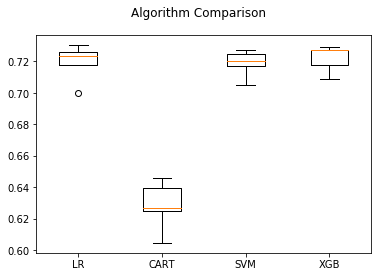

In [41]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the analysis above, logistic regression performs as well as the two black box models, support vector machines and gradient boosted trees.

We also notice that SVM takes a long time to train compared to Logistic Regression- this is a problem in a production setting.

Logisitic regression gives us a natural way of interpreting the model output- 'probabilities' of repaying a loan.  

---

## EDA and feature engineering

Logistic Regression requires the features to be uncorrelated, so we must remove or combine features so as to not have heavily correlated ones inlcuded in the model

In [42]:
# new features 
heloc_tmp=heloc.copy()

#We deal with highly correlated features by dropping or combining them where possible

heloc_tmp['x26']=(heloc['x2']-heloc['x3'])

heloc_tmp['x25']=heloc['x8']*heloc_tmp['x4']


#x2 and x4 are also highly correlated so we combine them
heloc_tmp['x26']= heloc['x2']/heloc['x4']

heloc_tmp['x27']=(.7*heloc['x16'])+(.3*heloc['x17'])-heloc['x15']

heloc_tmp['x28']=(heloc['x19']*heloc['x21'])/(heloc['x14']+1)

heloc_tmp['x29']=heloc['x21']/(heloc_tmp['x12']*heloc_tmp['x14']+0.1)#number of installment trades


heloc_tmp['x30']=heloc['x5']*heloc['x4']

In [43]:
corr = heloc.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
RiskFlag,1,0.45,0.21,0.045,0.24,0.14,-0.16,-0.13,0.25,0.016,0.23,0.21,0.098,-0.074,-0.14,0.16,-0.14,-0.13,-0.34,-0.085,-0.12,-0.051,-0.21,-0.27
x1,0.45,1,0.25,0.14,0.33,0.0045,-0.4,-0.33,0.52,0.018,0.57,0.51,-0.034,-0.18,-0.16,0.16,-0.2,-0.2,-0.61,-0.14,-0.33,-0.17,-0.41,-0.45
x2,0.21,0.25,1,0.1,0.68,0.24,-0.0089,-0.023,0.043,0.031,-0.0032,0.0011,0.27,-0.1,-0.19,0.086,-0.1,-0.099,-0.17,-0.1,0.12,-0.034,0.021,-0.21
x3,0.045,0.14,0.1,1,0.4,-0.25,0.029,0.03,-0.11,-0.039,0.0066,0.017,-0.22,-0.44,-0.0096,0.044,-0.16,-0.17,-0.056,-0.23,-0.16,-0.19,-0.094,-0.0068
x4,0.24,0.33,0.68,0.4,1,0.11,0.042,0.018,-0.04,0.03,-0.01,-0.03,0.089,-0.35,-0.2,0.088,-0.18,-0.17,-0.19,-0.21,0.013,-0.14,-0.033,-0.21
x5,0.14,0.0045,0.24,-0.25,0.11,1,-0.11,-0.11,0.27,0.025,-0.0041,0.04,0.85,0.31,-0.13,0.035,0.1,0.1,-0.07,0.12,0.48,0.38,0.26,-0.23
x6,-0.16,-0.4,-0.0089,0.029,0.042,-0.11,1,0.89,-0.52,0.15,-0.41,-0.57,-0.021,-0.048,0.12,-0.047,0.046,0.046,0.092,0.026,-0.042,0.049,-0.017,0.12
x7,-0.13,-0.33,-0.023,0.03,0.018,-0.11,0.89,1,-0.36,0.14,-0.35,-0.48,-0.035,-0.039,0.11,-0.039,0.05,0.05,0.065,0.03,-0.053,0.036,-0.027,0.1
x8,0.25,0.52,0.043,-0.11,-0.04,0.27,-0.52,-0.36,1,-0.085,0.51,0.64,0.17,0.16,-0.12,0.081,0.014,0.015,-0.16,0.055,0.086,0.068,0.04,-0.17
x9,0.016,0.018,0.031,-0.039,0.03,0.025,0.15,0.14,-0.085,1,0.073,-0.34,0.03,0.049,0.032,0.015,0.016,0.017,0.029,0.048,0.0075,0.029,0.011,0.02


In [44]:
features = heloc_tmp.columns.tolist()[1:] # updated list of features

heloc_train, heloc_test = train_test_split(heloc_tmp, test_size=0.2, random_state=GID) # 80/20 train/test split

In [45]:
# Binning

import scorecardpy as sc

heloc_train_tmp=heloc_train.copy()
heloc_test_tmp=heloc_test.copy()

for i in range(len(features)):
    bins = sc.woebin(heloc_train_tmp, y='RiskFlag',x=features[i], method='tree')
    breaks = np.insert(bins[features[i]]['breaks'].values.astype(np.float), 0, -np.inf)

    heloc_train_tmp[features[i]] = pd.cut(heloc_train_tmp[features[i]], bins=breaks, right=True)
    heloc_test_tmp[features[i]] = pd.cut(heloc_test_tmp[features[i]], bins=breaks, right=True)

[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


In [46]:
# Discretize into categorical variables

label_encoder = LabelEncoder()

for i in range(len(features)):
    heloc_train_tmp[features[i]] = label_encoder.fit_transform(heloc_train_tmp[features[i]])
    heloc_test_tmp[features[i]] = label_encoder.fit_transform(heloc_test_tmp[features[i]])

---

# Feature Selection

In [47]:
features_tmp = heloc_train_tmp.columns.tolist()[1:]
num_feats=len(features_tmp)
X = heloc_train_tmp.drop('RiskFlag', axis=1)
y = heloc_train_tmp['RiskFlag']

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

29 selected features


In [49]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(solver='newton-cg'), 
                   n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

29 selected features


In [50]:
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

27 selected features


In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

12 selected features


In [52]:
from sklearn.feature_selection import SelectFromModel

xgbc=XGBClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_xgb_selector = SelectFromModel(xgbc, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

11 selected features


In [53]:
feature_selection_df = pd.DataFrame(
    {'Feature':features_tmp, 'Chi-2':chi_support, 
     'RFE':rfe_support, 'Logistics':embeded_lr_support,
     'Random Forest':embeded_rf_support, 'XGB':embeded_xgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display features by importance
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [54]:
feature_selection_df

,Feature,Chi-2,RFE,Logistics,Random Forest,XGB,Total
1,x4,True,True,True,True,True,5
2,x30,True,True,True,True,True,5
3,x25,True,True,True,True,True,5
4,x23,True,True,True,True,True,5
5,x18,True,True,True,True,True,5
6,x15,True,True,True,True,True,5
7,x1,True,True,True,True,True,5
8,x8,True,True,True,False,True,4
9,x7,True,True,True,False,True,4
10,x29,True,True,True,True,False,4


Based on the ranked table of features, and on the correlation matrix, we remove variables

In [55]:
###
drop=feature_selection_df[feature_selection_df['Total'] <3]['Feature'].values
print(drop)

heloc_train = heloc_train_tmp.drop(drop,axis=1) # update heloc with removed features
heloc_test = heloc_test_tmp.drop(drop,axis=1) # update heloc with removed features


['x26' 'x17']


---

## Model Building

In [56]:
# split dataset into train and testing for model evaluation

X_train = heloc_train.drop('RiskFlag', axis=1)
y_train = heloc_train['RiskFlag']
X_test = heloc_test.drop('RiskFlag', axis=1)
y_test = heloc_test['RiskFlag']

In [57]:
## Hyperparameter tuning

param_grid_1 = dict(penalty = ['l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                    solver=[ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

param_grid_2 = dict(penalty = ['l1', 'l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    solver=['liblinear', 'saga'])


lr = LogisticRegression()

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_1,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Params:  {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.5s finished


## Model Evaluation

In [85]:
# Accuracy / Error rate
def accuracy(y_true, X, model):
    y_pred = model.predict(X)
    return accuracy_score(y_true, y_pred)

print('Training accuracy score: ', accuracy(y_train, X_train, grid))
print('Test accuracy score: ', accuracy(y_test, X_test, grid))

Training accuracy score:  0.7276204135293415
Test accuracy score:  0.7270554493307839


In [86]:
y_train_pred = grid.predict_proba(X_train)[:,1]
y_test_pred = grid.predict_proba(X_test)[:,1]

acc_train = roc_auc_score(y_train,y_train_pred)
acc_test = roc_auc_score(y_test,y_test_pred)
    
print('The ROC score on training set:',acc_train)
print('The ROC score on testing set:',acc_test)

The ROC score on training set: 0.7950967251886233
The ROC score on testing set: 0.7841887718148031


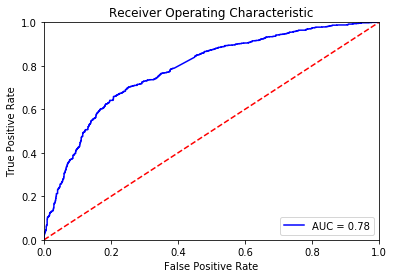

In [87]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Interpretation

#### Variable Importance

In [99]:
perm = PermutationImportance(grid).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=[i for i in X_train])

Weight,Feature
0.0196 ± 0.0056,x1
0.0078 ± 0.0025,x18
0.0056 ± 0.0027,x15
0.0054 ± 0.0030,x8
0.0047 ± 0.0033,x30
0.0042 ± 0.0035,x20
0.0032 ± 0.0012,x4
0.0030 ± 0.0019,x10
0.0026 ± 0.0040,x5
0.0021 ± 0.0016,x22


- Another visualization of feature importance is presented below

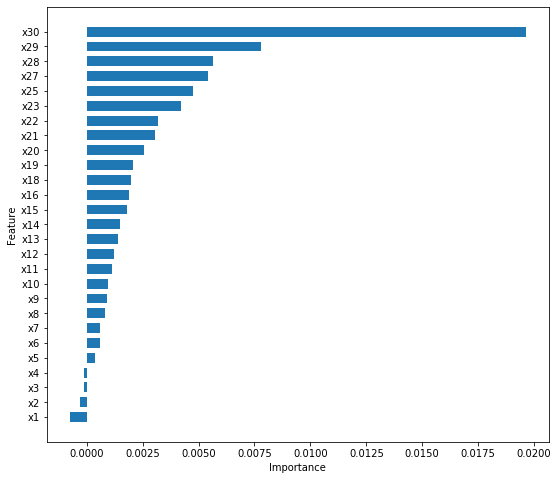

In [100]:
imp_ord = np.argsort(perm.feature_importances_)
plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm.feature_importances_))*1.2
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,[i for i in X_train])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

#### Partial Dependence Plot

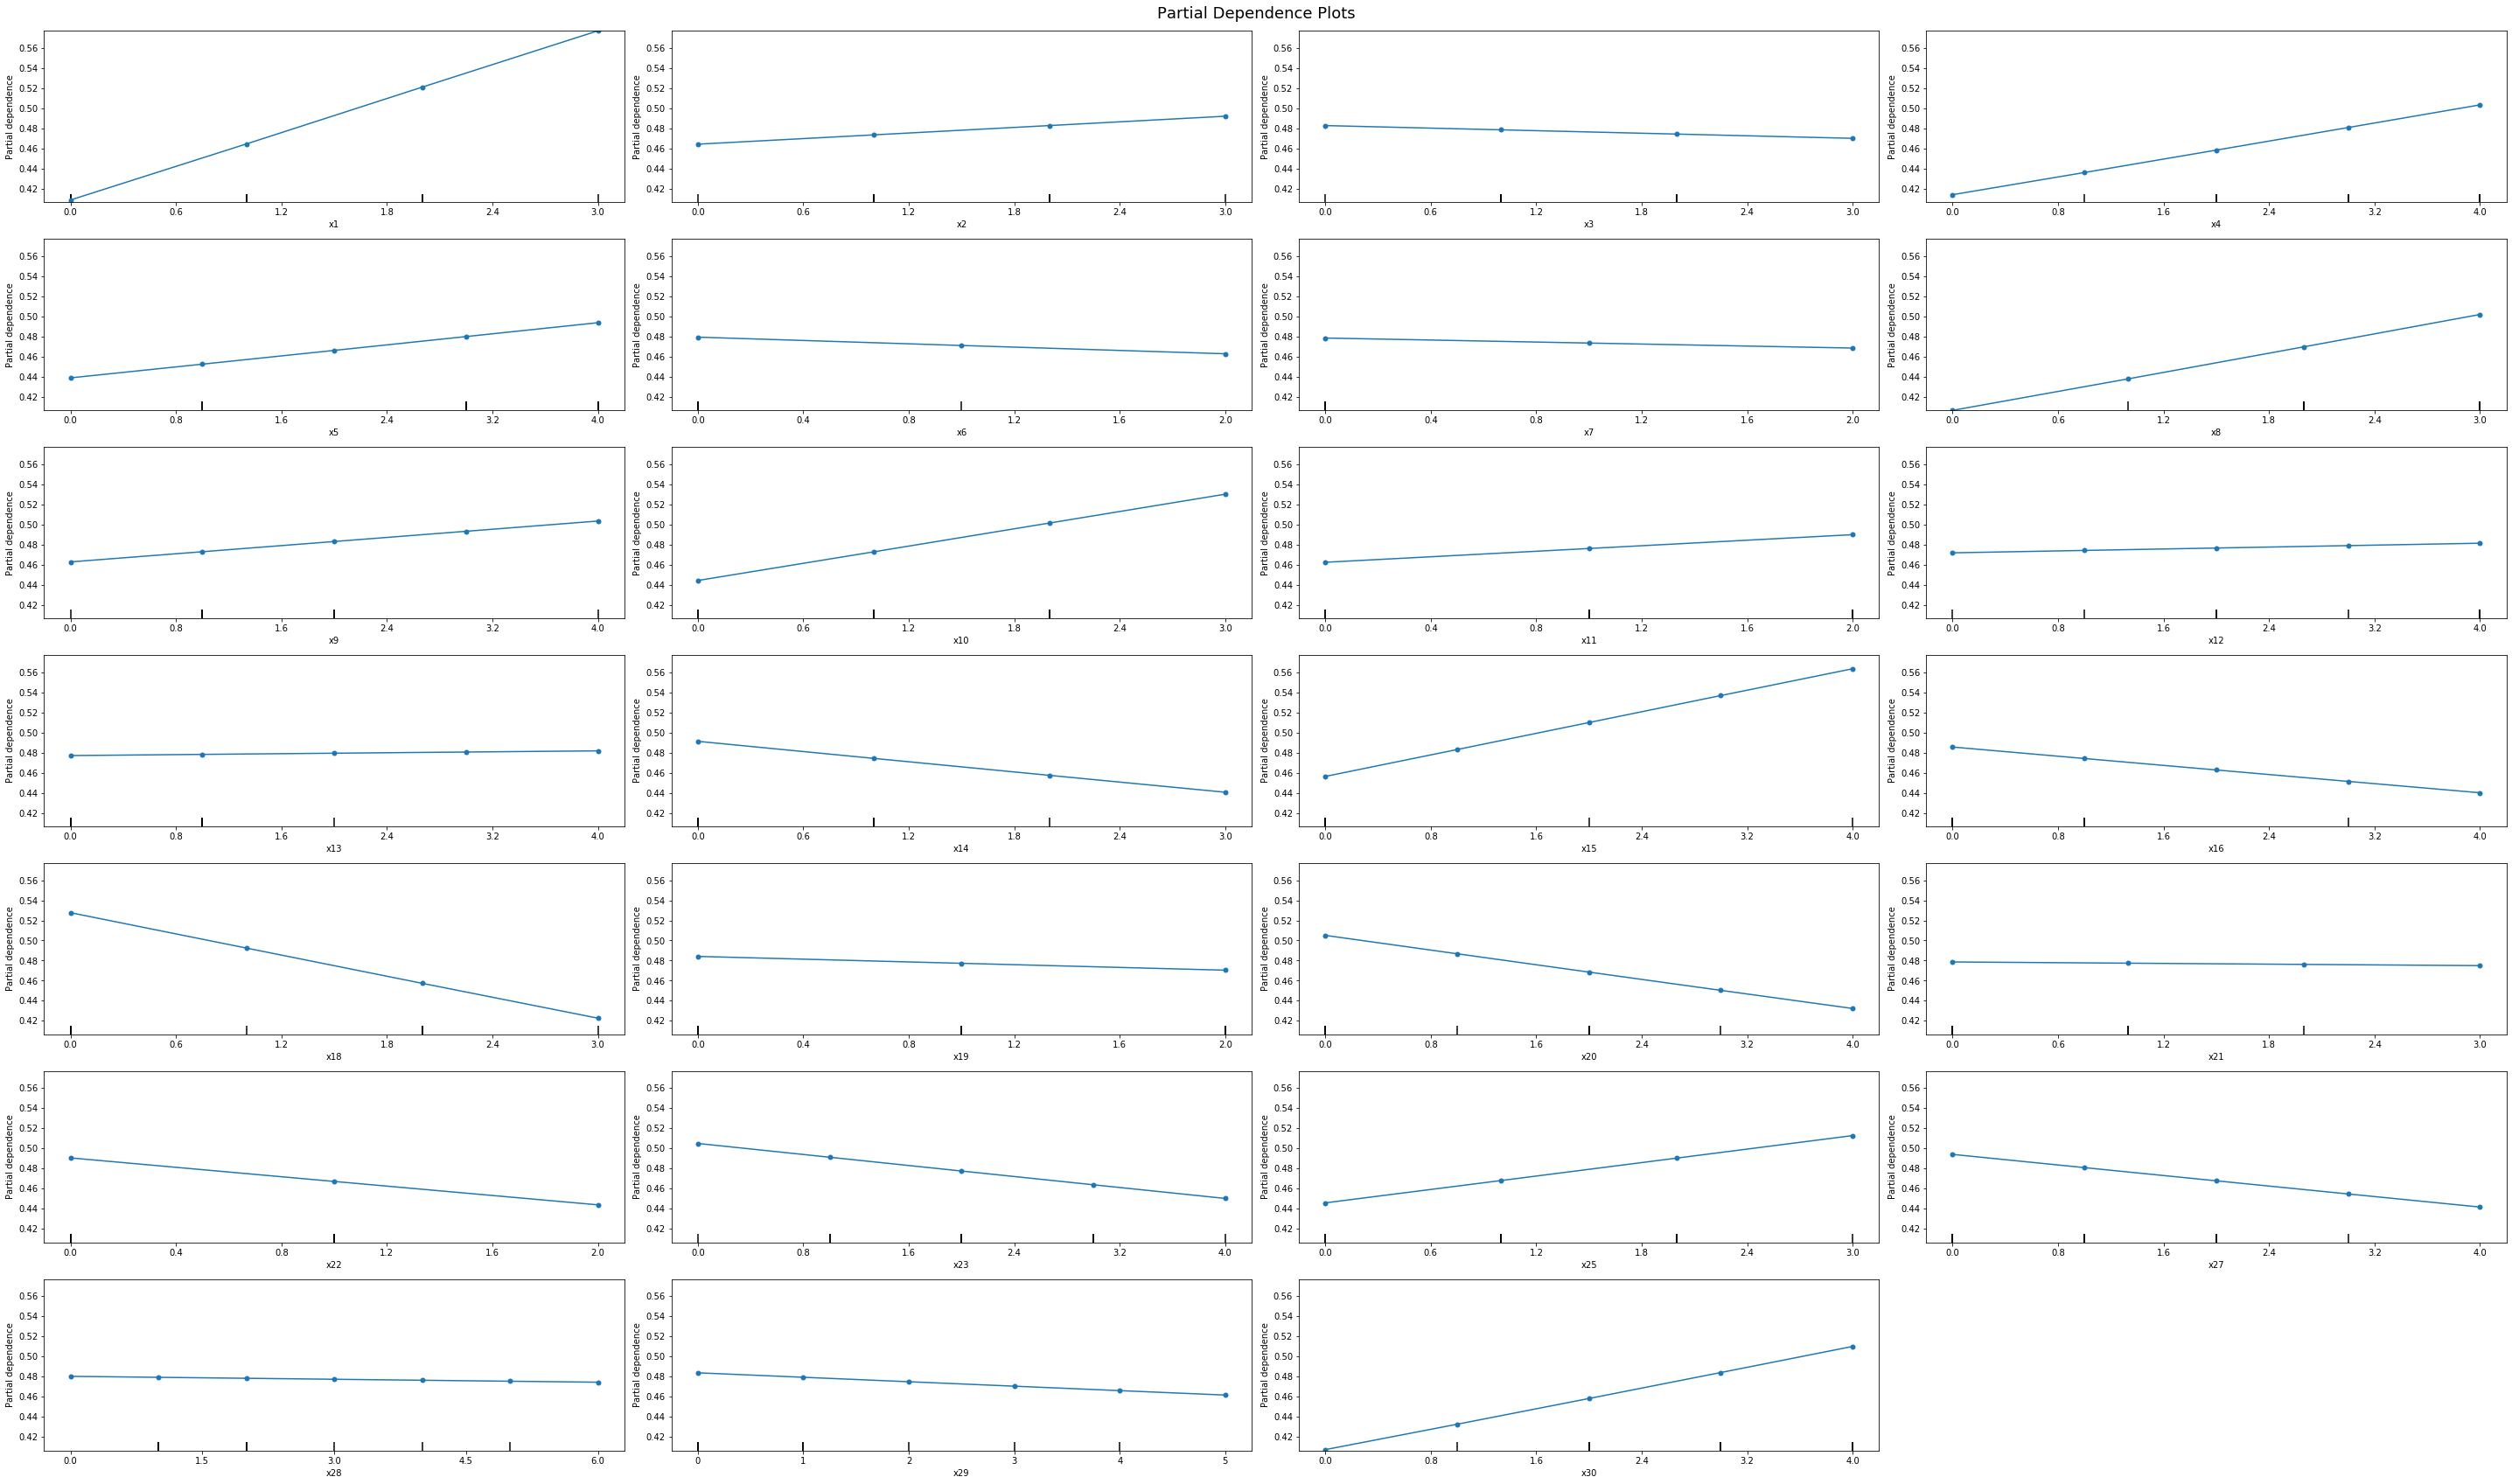

In [106]:
n_cols = 4
n_rows = 10//n_cols + 1

fig = plt.figure(figsize=(40, 8*n_rows))
pdp(grid, X_train, features=[i for i in X_train], feature_names=[i for i in X_train],
    n_cols=n_cols, fig=fig, line_kw={'marker': 'o', 'markeredgecolor': 'None'})

plt.suptitle('Partial Dependence Plots', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])

#### LIME

In [116]:
i = np.random.randint(0, X_test.shape[0])
pred_i = grid.predict_proba(X_test.iloc[[i], :])
print('Target: {:}'.format(pred_i[0, 1]))
X_test.iloc[[i], :]

Target: 0.27999277610805545


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x19,x20,x21,x22,x23,x25,x27,x28,x29,x30
1753,1,0,1,1,3,0,0,2,2,1,...,1,0,3,0,3,0,1,2,2,2


In [118]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=[i for i in X_train], 
                                                   class_names=['RiskFlag'], 
                                                   discretize_continuous=False)
exp = explainer.explain_instance(X_train.iloc[i], grid.predict_proba, top_labels=2)
exp.show_in_notebook(show_table=True,  predict_proba= True , show_predicted_value = True , show_all=False)

#### SHAP

In [120]:
shap.initjs()
explainer = shap.KernelExplainer(grid.predict_proba, shap.kmeans(X_train, 5))
shap_values = explainer.shap_values(X_train[:i])

In [135]:
explainer.expected_value

array([0.53869791, 0.46130209])

In [145]:
shap.force_plot(base_value=explainer.expected_value[1], shap_values=shap_values[1][-1],
                features=X_train.iloc[i], feature_names=[i for i in X_train])

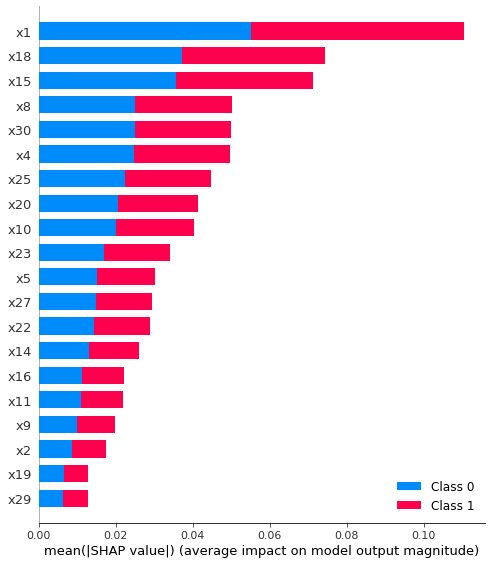

In [147]:
shap.summary_plot(shap_values, X_train[:n_explain],[i for i in X_train])